# Import Libs

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas_ta as ta


import os


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Define the parameters for data collection
- Import libs, set tickers/period
- download data with yf.download()
- save CSV to data/raw with to_csv().

In [2]:
# stock tickers
tickers = ['PETR4.SA', 'VALE3.SA']

# Time period
start_date = '2015-01-01'
end_date = '2025-01-01'
raw_data_path = 'data/raw'

# Create the folder if it does not exist
os.makedirs(raw_data_path, exist_ok=True)

# Collect and save data for each action
for ticker in tickers:
    print(f"Downloading data to {ticker}...")
    
    # Download data using the yfinance library
    df = yf.download(ticker, start = start_date, end = end_date)

    # Check if the DataFrame is not empty
    if not df.empty:
        # Reset the index to turn the date column into a regular column
        df.reset_index(inplace=True)
        
        # Save the DataFrame to a CSV file inside the 'data/raw' folder
        file_path = os.path.join(raw_data_path, f'{ticker.replace(".SA", "")}_raw.csv')
        df.to_csv(file_path, index=False)
        
        print(f"{ticker} data saved to: {file_path}")
        
    else:
        print(f"Error: Unable to download data for {ticker}.")

print("\nData collection complete.")

C:\Users\mathe\AppData\Local\Temp\ipykernel_18224\185356462.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\mathe\AppData\Local\Temp\ipykernel_18224\185356462.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start = start_date, end = end_date)


PETR4.SA data saved to: data/raw\PETR4_raw.csv


[*********************100%***********************]  1 of 1 completed

VALE3.SA data saved to: data/raw\VALE3_raw.csv

Data collection complete.


# Understanding Data


In [3]:
dfs = {}

tickers_no_suffix = ['PETR4', 'VALE3']

# Load saved data and perform inspection
for ticker in tickers_no_suffix:
    file_path = f"{raw_data_path}/{ticker}_raw.csv"
    
    try:
        # Load the file with the 'Date' column as the index
        df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

        df = df.iloc[1:].copy()
        df = df.astype('float64')
        
        # Ensure numeric columns are the correct type
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        dfs[ticker] = df
                
        print(f"\n{'=' * 50}")
        print(f"Quick Inspection for {ticker}")
        print(f"{'=' * 50}")

        print("\n### First 5 lines:")
        print(df.head())

        print("\n### DataFrame Information:")
        print(df.info())

        print("\n### Descriptive Statistics:")
        print(df.describe())

        print("\n### Missing Values:")
        print(df.isnull().sum())
        
        print("\n### Count of Unique Values (Top 5 columns):")
        
        for col in df.columns[:5]:
            print(f"- {col}: {df[col].nunique()} unique values")

    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Please run the data collection step again.")


Quick Inspection for PETR4

### First 5 lines:
               Close      High       Low      Open      Volume
Date                                                          
2015-01-02  2.630869  2.807947  2.628059  2.807947  49559500.0
2015-01-05  2.406009  2.583087  2.397577  2.569033  78385100.0
2015-01-06  2.327307  2.481899  2.259849  2.448170  84723300.0
2015-01-07  2.436927  2.453792  2.349794  2.406009  85531000.0
2015-01-08  2.594330  2.639302  2.456603  2.470657  83306300.0

### DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2487 entries, 2015-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2487 non-null   float64
 1   High    2487 non-null   float64
 2   Low     2487 non-null   float64
 3   Open    2487 non-null   float64
 4   Volume  2487 non-null   float64
dtypes: float64(5)
memory usage: 116.6 KB
None

### Descriptive Statistics:
             Close      

# Análise univariada

## 1. Série Temporal do Preço de Fechamento

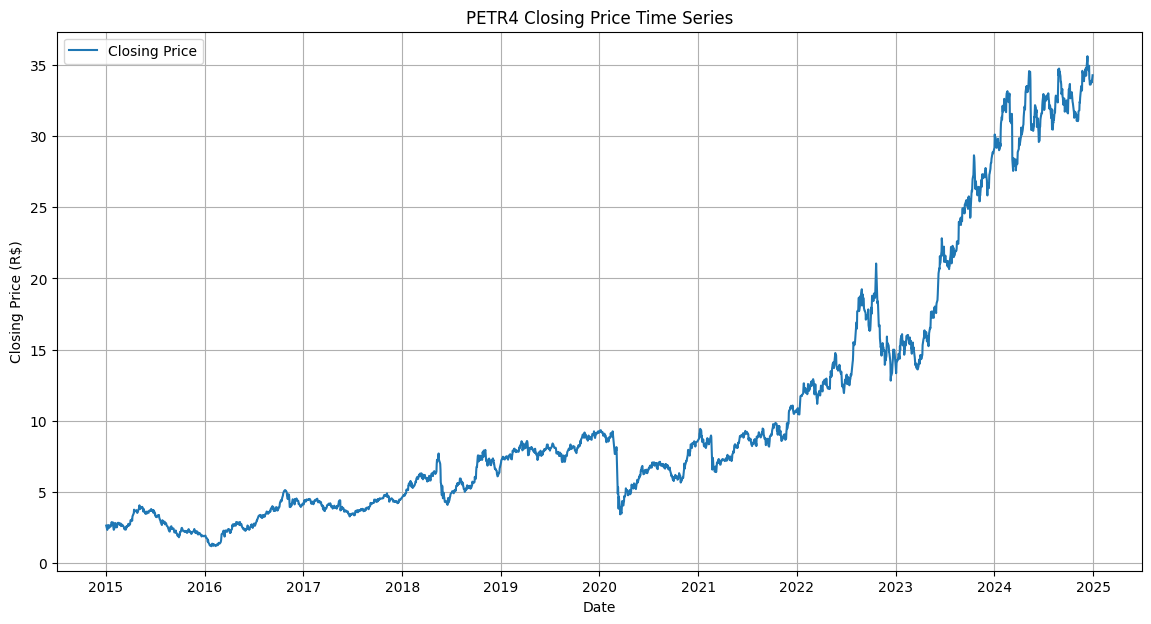

In [4]:
df_petr4 = dfs['PETR4']

plt.figure(figsize=(14, 7))
plt.plot(df_petr4.index, df_petr4['Close'], label='Closing Price')
plt.title('PETR4 Closing Price Time Series')
plt.xlabel('Date')
plt.ylabel('Closing Price (R$)')
plt.legend()
plt.grid(True)
plt.show()

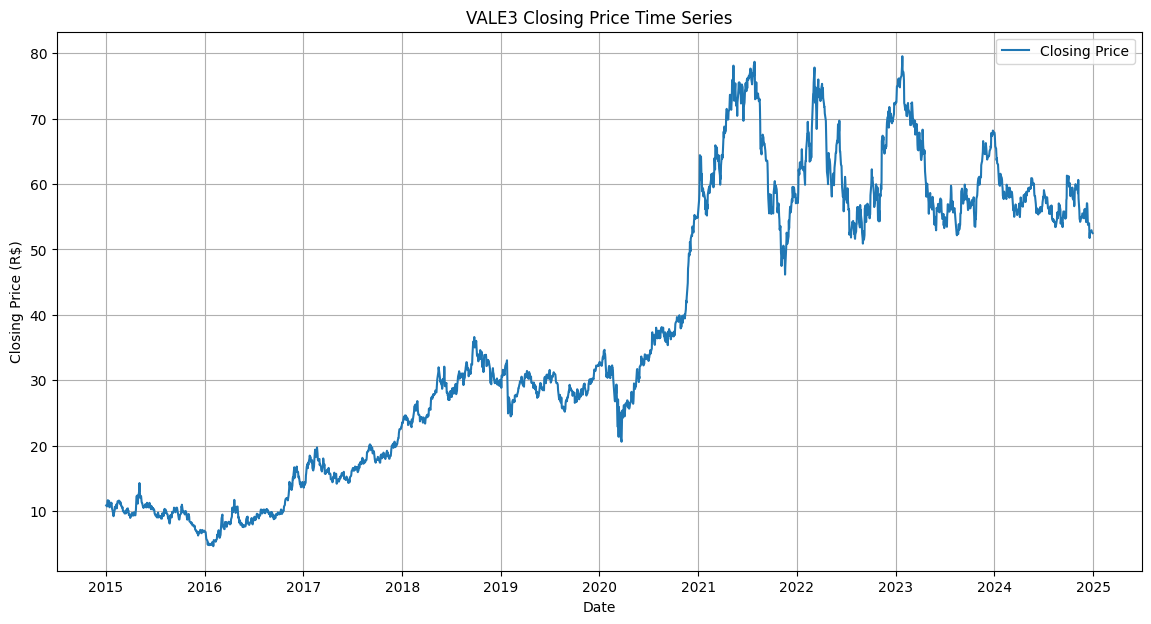

In [5]:
df_vale3 = dfs['VALE3']

plt.figure(figsize=(14, 7))
plt.plot(df_vale3.index, df_vale3['Close'], label='Closing Price')
plt.title('VALE3 Closing Price Time Series')
plt.xlabel('Date')
plt.ylabel('Closing Price (R$)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Histograma do Retorno Diário

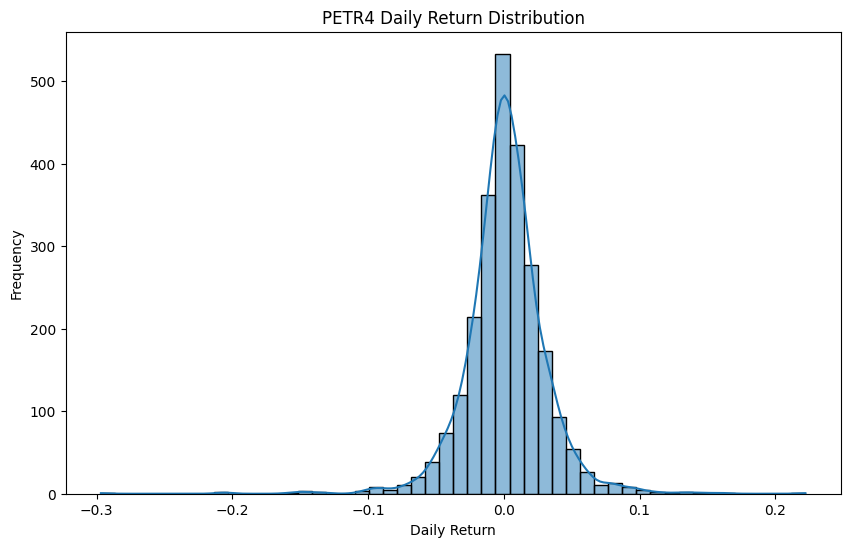

In [6]:
df_petr4['Daily_Return'] = df_petr4['Close'].pct_change()

plt.figure(figsize=(10, 6))
sns.histplot(df_petr4['Daily_Return'].dropna(), bins=50, kde=True)
plt.title('PETR4 Daily Return Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

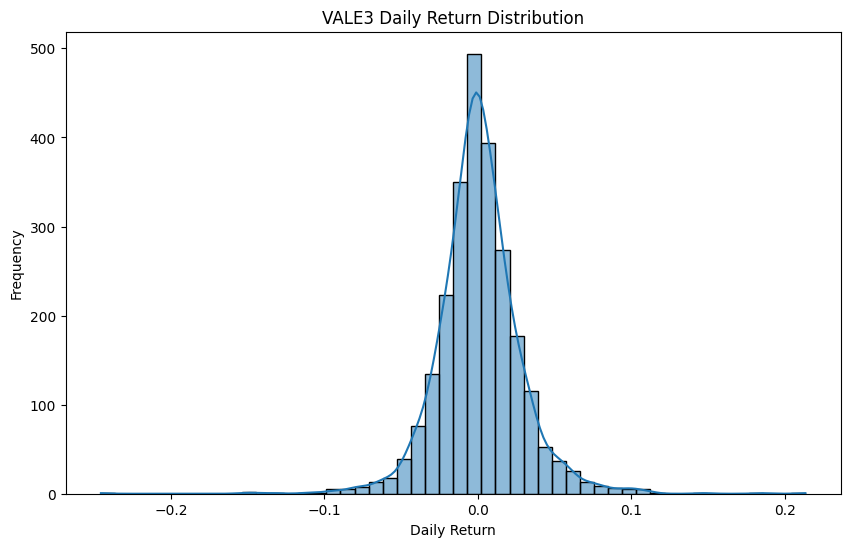

In [7]:
df_vale3['Daily_Return'] = df_vale3['Close'].pct_change()

plt.figure(figsize=(10, 6))
sns.histplot(df_vale3['Daily_Return'].dropna(), bins=50, kde=True)
plt.title('VALE3 Daily Return Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

## 3. Correlação de Retornos Diários (PETR4 vs. VALE3)

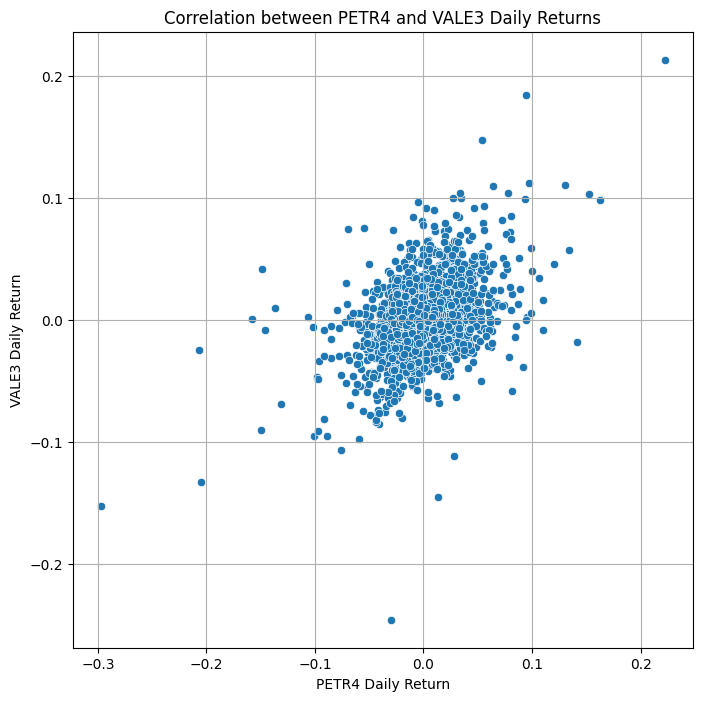

In [8]:
# Assuming you already have the DataFrames `dfs['PETR4']` and `dfs['VALE3']`
df_petr4['Daily_Return'] = df_petr4['Close'].pct_change()
df_vale3 = dfs['VALE3']
df_vale3['Daily_Return'] = df_vale3['Close'].pct_change()

# Create a new DataFrame with the daily returns of both stocks
returns_df = pd.DataFrame({
'PETR4_Return': df_petr4['Daily_Return'],
'VALE3_Return': df_vale3['Daily_Return']
}).dropna()

# Plot a scatterplot to visualize the correlation
plt.figure(figsize=(8, 8))
sns.scatterplot(x='PETR4_Return', y='VALE3_Return', data=returns_df)
plt.title('Correlation between PETR4 and VALE3 Daily Returns')
plt.xlabel('PETR4 Daily Return')
plt.ylabel('VALE3 Daily Return')
plt.grid(True)
plt.show()

# Engenharia de Features e Criação da Variável-Alvo com RSI e MACD

In [12]:
# process each DataFrame and store them in a new structure if necessary
processed_dfs = {}

for ticker, df in dfs.items():
    print(f"\nProcessing data for {ticker}...")

    df_processed = df.copy()

    #1. Remove unnecessary columns
    df = df[["Close", "Volume"]].copy()

    # 2 Feature Engineering
    df["Daily_Return"] = df["Close"].pct_change()

    # Calculate Simple Moving Averages (SMA)
    df["SMA_5"] = df["Close"].rolling(window = 5).mean()
    df["SMA_10"] = df["Close"].rolling(window = 10).mean()
    df["SMA_20"] = df["Close"].rolling(window = 20).mean()

    # Add RSI
    df_processed['RSI'] = ta.rsi(df_processed['Close'])
    
    # Add MACD
    macd_result = ta.macd(df_processed['Close'])
    df_processed['MACD'] = macd_result['MACD_12_26_9']

    # Create the Target Variable ('target')
    df["target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

    # 3. Data Treatment (Null Values)
    df.dropna(inplace = True)

    processed_dfs[ticker] = df
    print(f"Data for {ticker} Processed. New shape: {df.shape}")

combined_df = pd.concat(processed_dfs.values())

print(f"\nCombined DataFrame shape: {combined_df.shape}")
print("\First 5 rows of the combined and preprocessed DataFrame:")
print(combined_df.head())


Processing data for PETR4...
Data for PETR4 Processed. New shape: (2468, 7)

Processing data for VALE3...
Data for VALE3 Processed. New shape: (2468, 7)

Combined DataFrame shape: (4936, 7)
\First 5 rows of the combined and preprocessed DataFrame:
               Close       Volume  Daily_Return     SMA_5    SMA_10    SMA_20  \
Date                                                                            
2015-01-29  2.436927  111506300.0     -0.048299  2.683150  2.692144  2.607541   
2015-01-30  2.332930   87497200.0     -0.042676  2.588708  2.660102  2.592644   
2015-02-02  2.470656   57585100.0      0.059036  2.530245  2.649421  2.595876   
2015-02-03  2.802326   98061700.0      0.134244  2.520688  2.667972  2.619627   
2015-02-04  2.816380  117595000.0      0.005015  2.571844  2.671345  2.638599   

            target  
Date                
2015-01-29       0  
2015-01-30       1  
2015-02-02       1  
2015-02-03       1  
2015-02-04       0  


# split the data